In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random

# Books Dataset

We only extract the information we are interested in books dataset. ( s.t. ISBN, Title, Author, Year of Publication, Publisher).

In [2]:
def getBookDataset():
    books = pd.read_csv("BX-CSV-Dump/BX-Books.csv",sep="delimiter",engine='python')
    books.iloc[:,0] = books.iloc[:,0].apply(lambda x: x.split(";")[:-3])
    # reset the index as ISBN
    book_idx = [i[0].replace('"', '') for i in books.iloc[:,0].tolist()]
    book_idxSet = set(book_idx)
    books.index = book_idx
    # reset the header
    books.columns = ["Title"]
    # reset the content
    books["Author"] = books["Title"].apply(lambda x: x[2].replace('"', ''))
    books["Year of Publication"] = books["Title"].apply(lambda x: x[3].replace('"', ''))
    books["Publisher"] = books["Title"].apply(lambda x: x[4].replace('"', ''))
    books["Title"] = books["Title"].apply(lambda x: x[1].replace('"', ''))
    return books

books = getBookDataset()
books.head()

,Title,Author,Year of Publication,Publisher
0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp


# Users Dataset
Explores user's dataset.

In [3]:
def getUserDataset():
    def replaceAge(x):
        if x == "NULL":
            return 0
        else:
            return int(x[1:-1])

    users = pd.read_csv("BX-CSV-Dump/BX-Users.csv",sep="delimiter",engine='python')
    users.columns = ["Location"]
    # reset Age
    users["Age"] = users["Location"].apply(lambda x: replaceAge(x.split(";")[-1]))
    average_age = float(round(sum(users["Age"].tolist())/len(users)))
    users["Age"] = users["Age"].apply(lambda x: average_age if x == 0 else x)
    # reset index as user ID
    user_idx = [int(i.split(";")[0].replace('"', '')) for i in users.iloc[:,0].tolist()]
    user_idxSet = set(user_idx)
    users.index = user_idx
    # reset location
    users["Location"] = users["Location"].apply(lambda x: x.split(";")[1].split(",")[-1].replace('"', ''))
    return users

users = getUserDataset()
users.head()

,Location,Age
1,usa,21.0
2,usa,18.0
3,russia,21.0
4,portugal,17.0
5,united kingdom,21.0


# Ratings Dataset
## We extract the ratings from the rating dataset. 
There are a lot of error data in the rating dataset.

For example
 1. if the value of rating is 0, we think it is meaningless.
 2. Some ISBN in the rating dataset does not appear in the books dataset, we also think it is meaningless.

By cleaning up the data, we end up with clean data that we can use to operate.

In [5]:
def getBookRatings():
    bookRatings = pd.read_csv("BX-CSV-Dump/BX-Book-Ratings.csv",sep="delimiter",engine="python")
    bookRatings.columns = ["User-ID"]
    bookRatings["ISBN"] = bookRatings["User-ID"].apply(lambda x: x.split(";")[1].replace('"', ''))
    bookRatings["Rating"] = bookRatings["User-ID"].apply(lambda x: int(x.split(";")[-1].replace('"', '').replace(",","")))
    bookRatings["User-ID"] = bookRatings["User-ID"].apply(lambda x: x.split(";")[0].replace('"', ''))
    # drop the column which ISBN not exist
    ratingToDrop = bookRatings[bookRatings["ISBN"].apply(lambda x: not x in books.index)].index
    bookRatings = bookRatings.drop(ratingToDrop)
    # drop the column which rating is 0
    ratingToDrop = bookRatings[bookRatings["Rating"].apply(lambda x: x == 0)].index
    bookRatings = bookRatings.drop(ratingToDrop)
    bookRatings.head(10)
    return bookRatings

bookRatings = getBookRatings()
bookRatings.head(5)

,User-ID,ISBN,Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
8,276744,038550120X,7
16,276747,0060517794,9


## We can get the overview about the distribution of book ratings.

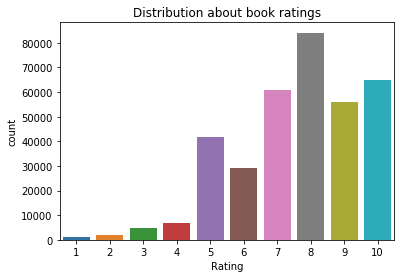

In [6]:
sns.countplot(data=bookRatings, x="Rating")
plt.title("Distribution about book ratings")
plt.show()

# Simple popularity based Recommend System
Since the Collaborative Filtering algorithm can only recommend books for users who have already rated a number of books, it is difficult for those who have not rated any books to calculate the degree of similarity with other users, so we can use this simple algorithm on them.

Recommend the most 10 popular books based on the number of ratings as well as the average value of rating.

We extract the books which has more than 150 ratings and calculate the average value of their ratings.

In [7]:
def simplePopularity(bookRatings, ds):
    bookCounts = bookRatings["ISBN"].value_counts()
    bookCounts = bookCounts[bookCounts >= 150]
    opBookRating = bookRatings[bookRatings["ISBN"].isin(bookCounts.index)]
    df = pd.DataFrame(opBookRating.groupby(["ISBN"])["Rating"].mean()).sort_values("Rating",ascending=False).head(10)
    out = ds.loc[df.index.tolist()]
    out["Rating"] = df["Rating"]
    return out
simplePopularity(bookRatings, books)


,Title,Author,Year of Publication,Publisher,Rating
043935806X,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003,Scholastic,9.015873
059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books,8.933333
0446310786,To Kill a Mockingbird,Harper Lee,1988,Little Brown &amp,8.923077
0439064872,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000,Scholastic,8.794118
0345361792,A Prayer for Owen Meany,John Irving,1990,Ballantine Books,8.628743
0385484518,"Tuesdays with Morrie: An Old Man, a Young Man,...",MITCH ALBOM,1997,Doubleday,8.593220
0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books,8.494700
0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,8.435556
0060930535,The Poisonwood Bible: A Novel,Barbara Kingsolver,1999,Perennial,8.199005
0804106304,The Joy Luck Club,Amy Tan,1994,Prentice Hall (K-12),8.179775


# Collaborative Filtering based Recommendation System

### Funtions used for CF-based recommendation systems
in order to speed up the operation of the program, we only consider users who have rated at least 100 books and books which have at least 100 ratings.

In [22]:

def generateUserBooksMatrix(bookRatings, userRatingBounds=100, bookRatingBounds=100):
    bookCounts = bookRatings["ISBN"].value_counts()
    userCounts = bookRatings["User-ID"].value_counts()
    # only keep the user and book which has over 100 ratings.
    userCounts = userCounts[userCounts >= userRatingBounds]
    bookCounts = bookCounts[bookCounts >= bookRatingBounds]

    newBookRating = bookRatings[bookRatings["ISBN"].isin(bookCounts.index)]
    newBookRating = newBookRating[newBookRating["User-ID"].isin(userCounts.index)]

    ubMatrix = newBookRating.pivot(index="User-ID", columns="ISBN", values="Rating")
    ubMatrix = ubMatrix.fillna(0)
    ubMatrix = ubMatrix.drop_duplicates()
    return ubMatrix


def cosSimilarity(matrix, df, userId):
    vector = pd.DataFrame(index=[userId],columns=matrix.index)
    pb = df.loc[userId].tolist()
    pb_mag = np.sqrt(sum([j**2 for j in pb]))
    for idx in matrix.index:
        if idx == userId:
            continue
        pa = matrix.loc[idx].tolist()
        sim = np.dot(pa,pb)/(np.sqrt(sum([i**2 for i in pa]))*pb_mag)
        vector[idx] = sim
    return vector

def correlationSimilarity(matrix, df, userId):
    vector = pd.DataFrame(index=[userId],columns=matrix.index)
    for idx in matrix.index:
        if idx == userId:
            continue
        opVector = pd.DataFrame([df.loc[userId], matrix.loc[idx]])
        opVector = opVector.loc[:, (opVector != 0).all(axis=0)]
        if len(opVector.columns.tolist()) <= 1:
            continue
        else:
            user_mean = opVector.iloc[0].mean()
            target_mean = opVector.iloc[1].mean()
            
            pb = opVector.iloc[0].apply(lambda x: x - user_mean).tolist()
            pa = opVector.iloc[1].apply(lambda x: x - user_mean).tolist()
            if len(set(pb)) == 1 or len(set(pa)) == 1:
                continue
            pb_mag = np.sqrt(sum([i**2 for i in pb]))
            pa_mag = np.sqrt(sum([j**2 for j in pa]))
            
            sim = np.dot(pa,pb)/(pa_mag*pb_mag)
            vector[idx] = sim
    return vector
    


# User-Based Collaborative Filtering

Here we recommend books for a user whose ID is "100459". You can change any ID which occurs in the database.

It is better to choose the user who have rated more than 100 books.


In [10]:
# find similar user of given userId
def findSimilarUser(userId, matrix, original_matrix=bookRatings, topSimilar=5, algorithm="cos"):

    # get User Vector
    userVector = original_matrix[original_matrix["User-ID"].isin([userId])]
    user_books = userVector["ISBN"].tolist()
    df = pd.DataFrame(index=[userId],columns=matrix.columns)
    valid_df = userVector[userVector["ISBN"].isin(df.columns)]
    df[valid_df["ISBN"]] = valid_df["Rating"].tolist()
    df = df.fillna(0)
    if sorted(df.loc[userId].tolist(), reverse=True)[0] == 0:
        return df, df
    # add it into the matrix.
    matrix = pd.concat([matrix, df])
    matrix = matrix.drop_duplicates()
    # compute similarity.
    if algorithm == "cos":
        simVector = cosSimilarity(matrix, df, userId)
    if algorithm == "correlation":
        simVector = correlationSimilarity(matrix, df, userId)
    # find top-n similar user
    simVector = simVector.sort_values(userId,axis=1,ascending=False).iloc[:, :topSimilar]
    return simVector, df

# rating vector of user, learning Matrixs, books dataframe.
def recommendBooksForUser(userVector, simVector, matrix, bookData=books, numberOfBooks=10):
    sim_usersMatrix = matrix.loc[simVector.columns.tolist()]
    l = []
    for col in userVector.columns:
        if userVector[col].values[0] == 0:
            # calculate the aggregration
            simlist = simVector.columns.tolist()
            weightSum = 0
            weight = 0
            for uid in simlist:
                ratingUI = sim_usersMatrix.loc[uid,col]
                simUI = simVector[uid].values[0]
                weightSum += ratingUI*simUI
                weight += simUI
            l.append((weightSum/weight, col))
    l = sorted(l, reverse=True)[: numberOfBooks]
    # print(l)
    print(f"Here is the {numberOfBooks} books we recommend to you: ")
    books_list = [i[1] for i in l]    
    return bookData.loc[books_list]


#### 1. Get the user-item rating matrix. 
You can reduce the value of the parameter to increase the amount of data, which will improve the accuracy of the recommendation, but will increase the operation time.
#### 2. Calculate similarity between users.
you can choose the algorithm to use ("cos", "correlation")
#### 3. Recommend books.
you can modify the number of books you want to recommend to user.

#### 4. Better to choose the user in this list
['100459', '100906', '101209', '101606', '101851', '102647', '102702', '102967', '104399', '104636', '105028', '105517', '10560', '105979', '106007', '107784', '107951', '109574', '109901', '110912', '110934', '110973', '112001', '113270', '113519', '114368', '114868', '114988', '115003', '11676', '117384', '11993', '122429', '122793', '123094', '123608', '123883', '123981', '12538', '125519', '126492', '126736', '127200', '127359', '12824', '128835', '129074', '129716', '12982', '129851', '130554', '130571', '132492', '133747', '134434', '135149', '135265', '13552', '136010', '136139', '136348', '136382', '13850', '138578', '138844', '140000', '140358', '141902', '142524', '143175', '143253', '143415', '14422', '145449', '146113', '146348', '147847', '148199', '148258', '148744', '149908', '150979', '153662', '15408', '15418', '156150', '156269', '156467', '157247', '157273', '158226', '158295', '158433', '159506', '160295', '162052', '162639', '162738', '163804', '164096', '164323', '165308', '165319', '165758', '166123', '16634', '166596', '16795', '168047', '168245', '169682', '170513', '170634', '171118', '172742', '173291', '173415', '174304', '177072', '177432', '177458', '178522', '17950', '179718', '179978', '180651', '181176', '182085', '182993', '183995', '184299', '184532', '185233', '185384', '187145', '187256', '187517', '189139', '189334', '189835', '189973', '190708', '19085', '190925', '193458', '193898', '194600', '196077', '196160', '196502', '197659', '200226', '201290', '203240', '2033', '204864', '205735', '206534', '207782', '208406', '208671', '209516', '21014', '210485', '2110', '211426', '211919', '214786', '216444', '216683', '217318', '217740', '218552', '218608', '219546', '219683', '222296', '223087', '223501', '224349', '224525', '224646', '224764', '225087', '225199', '225595', '225763', '226965', '227447', '227520', '2276', '227705', '229011', '229329', '229551', '229741', '230522', '231210', '232131', '232945', '233911', '234359', '234828', '235105', '235282', '235935', '236058', '236283', '236340', '236757', '23768', '23872', '23902', '239584', '239594', '240144', '240403', '240567', '240568', '241666', '241980', '242083', '242409', '244627', '244685', '245410', '245827', '246311', '247429', '247447', '248718', '249894', '250709', '25409', '25601', '25981', '26535', '26544', '277427', '28591', '28634', '29259', '30276', '30511', '30711', '30735', '31315', '31556', '31826', '32773', '35836', '35857', '35859', '36554', '36606', '36609', '36907', '37644', '37712', '37950', '38023', '38273', '38281', '39281', '39467', '4017', '40889', '40943', '43246', '4385', '43910', '46398', '47316', '48025', '48494', '51883', '52199', '52350', '52584', '52917', '53220', '55187', '55490', '55492', '5582', '56399', '56447', '56554', '56959', '59172', '60244', '60337', '60707', '6242', '6251', '63956', '65258', '6543', '6575', '66942', '67840', '68555', '69078', '69389', '69697', '70415', '70594', '70666', '7286', '7346', '73681', '75591', '75819', '76151', '76223', '76499', '76626', '78783', '78834', '78973', '79441', '8067', '81492', '81560', '8245', '83287', '83637', '83671', '85526', '86189', '8681', '87141', '87555', '88283', '88677', '88693', '88733', '89602', '91113', '92652', '92810', '93047', '93363', '93629', '94242', '94347', '94853', '94951', '95010', '95359', '95932', '96448', '97754', '97874', '98391', '98758']

In [17]:
# Recommend 10 books for a user by given ID.
def user_basedCF(uid, alg, ub,bb,topSim):
    ubMatrix = generateUserBooksMatrix(bookRatings,ub,bb)
    #print(ubMatrix.shape)
    simVector, userVector = findSimilarUser(uid, algorithm=alg, topSimilar=topSim,matrix=ubMatrix)
    # print(simVector)
    if sorted(userVector.loc[uid].tolist(), reverse=True)[0] == 0:
        print("This user do not have valid data in our user-item matrix:")
        return simplePopularity(bookRatings, books)
    return recommendBooksForUser(userVector, simVector,matrix=ubMatrix)


user_basedCF("100459","correlation",100,100,5)
# generateUserBooksMatrix(bookRatings,100,100)

Here is the 10 books we recommend to you: 


,Title,Author,Year of Publication,Publisher
0061009059,One for the Money (Stephanie Plum Novels (Pape...,Janet Evanovich,1995,HarperTorch
0060934417,Bel Canto: A Novel,Ann Patchett,2002,Perennial
0446610038,1st to Die: A Novel,James Patterson,2002,Warner Vision
0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
0060915544,The Bean Trees,Barbara Kingsolver,1989,Perennial
043935806X,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003,Scholastic
0345370775,Jurassic Park,Michael Crichton,1999,Ballantine Books
0375726403,Empire Falls,Richard Russo,2002,Vintage Books USA
0671003755,She's Come Undone (Oprah's Book Club (Paperback)),Wally Lamb,1996,Washington Square Press
0385265700,The Book of Ruth (Oprah's Book Club (Paperback)),Jane Hamilton,1990,Anchor


# Item-Based Collaborative Filtering

Here we recommend books for a user whose ID is "100459". You can change any ID which occurs in the database.

It is better to choose the user who have rated more than 100 books.

In [23]:
# Item-Based

def itemRatedByUser(uid, matrix):
    userVector = pd.DataFrame(index=[uid])
    if not uid in matrix.columns:
        return userVector
    for idx in matrix.index.tolist():
        if matrix.loc[idx,uid] != 0:
            userVector[idx] = matrix.loc[idx,uid]
    return userVector


# find similar item of given ISBN
def findSimilarItem(itemId, itemRated,algorithm, matrix, original_matrix=bookRatings, topSimilar=5):
    # comupute cos similarity between vector a and b.

    # get Item Vector
    df = matrix.loc[[itemId]]
    
    rated_matrix = matrix.loc[itemRated.columns]
    # add it into the matrix.
    rated_matrix = pd.concat([rated_matrix, df])
    rated_matrix = rated_matrix.drop_duplicates()
    # compute similarity.
    if algorithm == "cos":
        simVector = cosSimilarity(rated_matrix, df, itemId)
    if algorithm == "correlation":
        simVector = correlationSimilarity(rated_matrix, df, itemId)
    # find top-n similar user
    simVector = simVector.sort_values(itemId,axis=1,ascending=False).iloc[:, :topSimilar]
    simVector = simVector.dropna(axis=1,how='all')
    return simVector

def recommendBooksForUser_IB(userId, ibMatrix,itemRated, bookData=books, numberOfBooks=10, topSimilar=5, algorithm="cos"):
    # create user Vector
    df = pd.DataFrame(index=[userId])
    l = []
    for bookid in ibMatrix.index.tolist():
        if ibMatrix.loc[bookid,userId] == 0:
            # find top-n same items.
            simVector = findSimilarItem(bookid,itemRated,algorithm,matrix=ibMatrix,topSimilar=topSimilar)
            # compute the weighted sum:
            simlist = simVector.columns.tolist()
            weightSum = 0
            weight = 0
            for i in simlist:
                weightUI = simVector[i].values[0]
                ratingUI = itemRated[i].values[0]
                if ratingUI == 0:
                    continue
                weightSum += ratingUI*weightUI
                weight += weightUI
            if weight == 0:
                continue
            l.append((weightSum/weight, bookid))
    l = sorted(l, reverse=True)[: numberOfBooks]
    #print(l)
    books_list = [i[1] for i in l]
    print(f"Here is the {numberOfBooks} books we recommend to you: ")
    return bookData.loc[books_list]



### It may takes a couple of time to run this algorithm.

#### 1.  Get the item-user rating matrix. 
You can reduce the value of the parameter to increase the amount of data, which will improve the accuracy of the recommendation, but will increase the operation time.
#### 2.  Get the item which have already been rated by this user.
#### 3.  Recommend.
For each item which have not been rated by this user, calculated the similarity between this item and other rated items, calculate the estimate rating based on the weighted average of other rated items


In [24]:
# Run
def item_basedCF(uid,alg,ub,bb,topSim):
    ibMatrix = generateUserBooksMatrix(bookRatings, ub, bb).T
    itemRated = itemRatedByUser(uid,matrix=ibMatrix)
    if itemRated.columns.tolist() == []:
        print("This user do not have valid data in our user-item matrix:")
        return simplePopularity(bookRatings, books)
    return recommendBooksForUser_IB(uid,ibMatrix, itemRated, algorithm=alg,topSimilar=topSim)

item_basedCF("100459","correlation",100,100,5)

Here is the 10 books we recommend to you: 


,Title,Author,Year of Publication,Publisher
0590353403,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,1998,Scholastic
0312291639,The Nanny Diaries: A Novel,Emma McLaughlin,2003,St. Martin's Griffin
0060938455,Fast Food Nation: The Dark Side of the All-Ame...,Eric Schlosser,2002,Perennial
0842329129,Left Behind: A Novel of the Earth's Last Days ...,Tim Lahaye,1996,Tyndale House Publishers
0440222656,The Horse Whisperer,Nicholas Evans,1996,Dell
0449212602,The Handmaid's Tale,Margaret Atwood,1989,Fawcett Books
0312983271,Full House (Janet Evanovich's Full Series),Janet Evanovich,2002,St. Martin's Paperbacks
0375700757,Cold Mountain : A Novel,CHARLES FRAZIER,1998,Vintage
068484477X,STONES FROM THE RIVER,Ursula Hegi,1997,Touchstone
0060930535,The Poisonwood Bible: A Novel,Barbara Kingsolver,1999,Perennial


# Evaluation


In [1003]:
# def predictBookScore_UB(userid, bookid, matrix, topSimilar, algorithm):
#     matrix.loc[userid, bookid] = 0
#     userVector = matrix.loc[[userid]]
#     print(userVector)
#     if algorithm == "cos":
#         simVector = cosSimilarity(matrix, userVector, userid)
#     if algorithm == "correlation":
#         simVector = correlationSimilarity(matrix, userVector, userid)
#     simVector = simVector.sort_values(userid,axis=1,ascending=False).iloc[:, :topSimilar]
#     sumWeight = 0
#     weightSum = 0
#     for uid in simVector.columns.tolist():
#         weightUI = simVector.loc[userid, uid]
#         valueUI = matrix.loc[uid,bookid]
#         weightSum += weightUI*valueUI
#         sumWeight += weightUI
#     if sumWeight == 0:
#         return 0
#     return weightSum/sumWeight
        
    



# ub_forTest = generateUserBooksMatrix(bookRatings,100,100)
# test_setIndex = [random.randrange(len(ub_forTest)) for _ in range(1)]

# test_user = ub_forTest.iloc[test_setIndex]
# print(test_user.index.tolist())
# for idx in test_user.index.tolist():
#     for bid in test_user.columns.tolist():
#         realValue = ub_forTest.loc[idx,bid]
#         if realValue != 0:
#             predictValue = predictBookScore_UB(idx, bid, ub_forTest, 5, "correlation")
#             ub_forTest.loc[idx,bid] = realValue
#             print(ub_forTest.loc[idx,bid],predictValue)


['165308']
ISBN     0060392452  0060502258  0060915544  0060928336  0060930535  \
User-ID                                                               
165308          0.0         0.0         0.0         0.0         0.0   

ISBN     0060934417  0060938455  0060959037  0060976845  0060987103  ...  \
User-ID                                                              ...   
165308          0.0         0.0         9.0         0.0         9.0  ...   

ISBN     0743418174  0786868716  0804106304  0804114986  0805063897  \
User-ID                                                               
165308          0.0         0.0         0.0         0.0         0.0   

ISBN     0812550706  0842329129  0971880107  1400034779  1558743669  
User-ID                                                              
165308          0.0         0.0         0.0         0.0         0.0  

[1 rows x 121 columns]


KeyboardInterrupt: 

In [ ]:
V